In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [11]:
import pymc3

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import pprint
%matplotlib inline

In [13]:
d = open("grit_data.txt","r").readlines()

In [14]:
data = pd.DataFrame()
for feature in d:
    f = feature.split(" ")
    data[f[0].strip(": ")] = list(map(lambda x: float(x),f[1:-1]))
data

,success,iq,years_in_school,grit
0,33.48,112.0,12.0,2.2
1,42.53,94.0,14.0,3.2
2,48.53,118.0,18.0,3.4
3,30.21,87.0,10.0,1.8
4,38.76,96.0,13.0,2.8
5,38.59,106.0,22.0,0.2
6,52.93,71.0,17.0,4.4
7,32.65,91.0,15.0,1.0
8,52.42,95.0,16.0,4.6
9,22.22,94.0,9.0,0.4


# Modelling relation between years_in_school and sucess

## Assumptions

X = years_in_school

Y = success

## Model
$X$ ~ $\mathcal{N}(\mu, \tau)$
--
$Y_i$ ~ $\mathcal{N}(b_0 + b_1x_i, \tau)$
--
## Paramaters

$b_0$ ~ $\mathcal{N}(\mu_0, \tau_0)$ --> Model intercept
--
$b_1$ ~ $\mathcal{N}(\mu_1, \tau_1)$ --> Model slope 
--
The precision must be positive, so we choose a gamma distribution.
--
$\tau$ ~ $gamma(\alpha_0,\beta_0)$ --> Model precision = $\frac{1}{\sigma^{2}}$
--

## Hyper parameters
We will use vague priors (non-informative) for the model parameters $b_0, b_1$ 

### Intercept Prior
$\mu_0 = 0$
----------
$\tau_0 = 0.0001$ --> $\sigma^{2}=10000$
---------
### Slope Prior
$\mu_1 = 0$
---------
$\tau_1 = 0.0001$ --> $\sigma^{2}=10000$
---------

### The prior for $\tau$ is heavily shifted towards low numbers which means $high$ varianace.
$\alpha_0 = 0.01$
----------
$\beta_0 = 0.01$
---------

In [15]:
#columns = ["trail", "samples", "mu0", "tau0", "b0", "mu1", "tau1", "b1", "alpha0", "beta0", "tau"]
#trace = pd.DataFrame(columns = columns, )
#trace = {
#    "b0_proposal":{"mu0":list(range()), "tau0", "b0",}
#}

# create object to trace all out sampling steps

In [16]:
def get_trace(TRAILS, SAMPLES):
    trace = {
        "trail": list(i for i in range(TRAILS)),
        "samples":list(SAMPLES for _ in range(TRAILS)),
        
        #"mu0_prior": None,
        #"tau0_prior": None,
        "mu0": list(None for i in range(TRAILS)),
        "tau0": list(None for i in range(TRAILS)), 
        "proposal_b0": list(None for i in range(TRAILS)), 
        
        #"mu1_prior": None,
        #"tau1_prior": None,
        "mu1": list(None for i in range(TRAILS)), 
        "tau1": list(None for i in range(TRAILS)),
        "proposal_b1": list(None for i in range(TRAILS)),

        "SSE": list(None for i in range(TRAILS)), # Sum squared error
        "predicted": list([] for i in range(TRAILS)), # a liast of predicted values for each y_i will be generated at each trail
        
        #"alpha_prior": None,
        #"beta_prior": None,
        "alpha": list(None for i in range(TRAILS)),
        "beta": list(None for i in range(TRAILS)),
        "proposal_tau": list(None for i in range(TRAILS))
    }
    return trace
#trace = get_trace(TRAILS=10, SAMPLES=len(data))

# Set Prior distributions

In [536]:
def set_priors(trace):
    trace["mu0"][0] = 0
    trace["tau0"][0] = 0.0001
    trace["mu1"][0] = 0
    trace["tau1"][0] = 0.0001
    trace["alpha"][0] = 0.01
    trace["beta"][0] = 0.01
    return trace

#trace = set_priors(trace)

# Prime our MCMC sampler

In [537]:
def prime_MCMC(trace):
    trace["proposal_b0"][0] = 6
    trace["proposal_b1"][0] = 0.3
    # Tau needed not to be set here in the first step since we will sample this conditioned on b0 and b1
    trace["proposal_tau"][0] = None 
    return trace
#trace = prime_MCMC(trace)

In [559]:
import scipy.stats as stats
import numpy as np

In [573]:
def compute_SSE(trace, data, trail):
    for _, observation in data.iterrows():
        trace["predicted"][trail].append(trace["proposal_b0"][trail] + trace["proposal_b1"][trail] * observation["years_in_school"])
    diff = data["success"].values - np.array(trace["predicted"][trail])
    trace["SSE"][trail] = sum([x**2 for x in diff]) #diff.dot(diff)
    return 

In [574]:
def update_tau_parameters(trace, trail):
    """Update the proposal distribution of tau, conditioned on the current values of b0 and b1"""
    
    # the prior of alpha and beta is always chosen as the first term in the conjugate solution update.
    # and we have always the same sample size
    n = trace["samples"][0]
    alpha_prior = trace["alpha"][0]
    trace["alpha"][trail] = alpha_prior + (n / 2)
    
    # We use the previous rounds Sum squared error to update beta. i.e the intercept and slope from the previous
    # round is used to update beta.
    beta_prior = trace["beta"][0]
    trace["beta"][trail] = beta_prior + (trace["SSE"][trail-1] / 2)
    return 

In [582]:
from scipy.stats import gamma

def update_tau_proposal(trace, trail):
    # numpy uses scale = 1/rate
    trace["proposal_tau"][trail] = np.random.gamma(shape=trace["alpha"][trail], scale=(1/trace["beta"][trail]))
    #trace["proposal_tau"][trail] = gamma.rvs(a=trace["alpha"][trail], scale=(1/trace["beta"][trail]))[0]
    return

In [583]:
def update_b0_parameters(trace, data, trail):
    
    tau0_prior = trace["tau0"][0]
    mu0_prior = trace["mu0"][0]
    n = trace["samples"][0]
    
    trace["mu0"][trail] = ((tau0_prior * mu0_prior) + \
                        trace["proposal_tau"][trail] * \
                        sum([
                            obs["success"] - (trace["proposal_b1"][trail-1] * obs["years_in_school"])
                        for _, obs in data.iterrows()])) / (tau0_prior + n * trace["proposal_tau"][trail])
    
    trace["tau0"][trail] = tau0_prior + (n * trace["proposal_tau"][trail])
    
    return

In [584]:
def update_b0_proposal(trace, trail):
    mu = trace["mu0"][trail]
    var = 1/trace["tau0"][trail]
    trace["proposal_b0"][trail] = np.random.normal(mu, np.sqrt(var))
    return

In [585]:
def update_b1_parameters(trace, data, trail):
    
    tau1_prior = trace["tau1"][0]
    mu1_prior = trace["mu1"][0]
    n = trace["samples"][0]
    squared_data = sum([obs["years_in_school"] for _, obs in data.iterrows()])**2
    
    trace["mu1"][trail] = ((tau1_prior * mu1_prior) + \
                        trace["proposal_tau"][trail] * \
                        sum([
                             obs["years_in_school"] * (obs["success"] - trace["proposal_b0"][trail])
                        for _, obs in data.iterrows()])) / (tau1_prior + (trace["proposal_tau"][trail] * squared_data))
    
    trace["tau1"][trail] = (tau1_prior + (trace["proposal_tau"][trail] * squared_data))
    
    return

In [586]:
def update_b1_proposal(trace, trail):
    mu = trace["mu1"][trail]
    var = 1/trace["tau1"][trail]
    trace["proposal_b1"][trail] = np.random.normal(mu, np.sqrt(var))
    return

In [587]:
from tqdm.notebook import tqdm

In [588]:
def GIBBS_sampler(trace, TRAILS):
    
    # first we need the Sum squared error to update Tau in the first round
    compute_SSE(trace, data, 0)
    
    # Now comes the rest of the trails..
    for trail in tqdm(range(1, TRAILS)): 
        
        #update tau (error term)
        update_tau_parameters(trace, trail)
        update_tau_proposal(trace, trail)
        
        #update intercept
        update_b0_parameters(trace, data, trail)
        update_b0_proposal(trace, trail)
        #trace["mu0"][trail] = 33.387
        #trace["tau0"][trail] = 0.0151
        #trace["proposal_b0"][trail] = 31.888
        
        #update slope
        update_b1_parameters(trace, data, trail)
        update_b1_proposal(trace, trail)
        #trace["mu1"][trail] = 0.538
        #trace["tau1"][trail] = 3.65
        #trace["proposal_b1"][trail] = -0.180
        
        # Compute sum squared error
        compute_SSE(trace, data, trail)
        
    return trace

TRAILS=100
burn_in = int(TRAILS * 0.25)
trace = get_trace(TRAILS,
                  SAMPLES=len(data))

trace = set_priors(trace)
trace = prime_MCMC(trace)
trace = GIBBS_sampler(trace, TRAILS)

In [548]:
import collections

trace_ordered = collections.OrderedDict(sorted(trace.items()))
trace_ordered

OrderedDict([('SSE',
              [13055.0668,
               2336.5852942892984,
               1941.8458745133516,
               1856.3382173068885,
               1929.9705628959614,
               1941.1559779624852,
               2069.616666861605,
               1981.527200831562,
               2451.695591022145,
               2026.0131241034765,
               2030.6388004732257,
               2166.626248086231,
               2047.3521585773583,
               1808.7830664340227,
               2069.715107056724,
               1832.8409826120017,
               1930.5540555079524,
               1762.8878168260003,
               2641.030949114227,
               1998.6923235259237,
               2030.6879934864749,
               2323.287088759796,
               1996.4800391687354,
               1963.2868469971597,
               1974.5422405602471,
               2132.8171037668253,
               2581.354027531005,
               2353.2103591527175,
               

In [549]:
#trace = {key:trace[key][int(burn_in):] for key in trace}

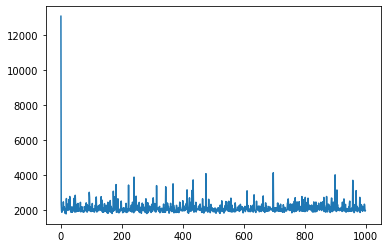

[13055.0668,
 2336.5852942892984,
 1941.8458745133516,
 1856.3382173068885,
 1929.9705628959614,
 1941.1559779624852,
 2069.616666861605,
 1981.527200831562,
 2451.695591022145,
 2026.0131241034765,
 2030.6388004732257,
 2166.626248086231,
 2047.3521585773583,
 1808.7830664340227,
 2069.715107056724,
 1832.8409826120017,
 1930.5540555079524,
 1762.8878168260003,
 2641.030949114227,
 1998.6923235259237,
 2030.6879934864749,
 2323.287088759796,
 1996.4800391687354,
 1963.2868469971597,
 1974.5422405602471,
 2132.8171037668253,
 2581.354027531005,
 2353.2103591527175,
 2037.116457851937,
 2759.025448797068,
 2006.1823796302288,
 1958.7806413308144,
 1944.613118122755,
 1861.7920347646234,
 2011.9217615010405,
 1868.324215488597,
 2169.3564825874355,
 1853.7015060662227,
 2083.4616404829558,
 2018.0127998733437,
 1935.8661574434193,
 1989.0816176309486,
 2281.0288619012676,
 2650.0340706768116,
 1936.64775524921,
 1872.5671836873078,
 2195.506331886529,
 2827.6896789286234,
 2390.664373264

In [550]:
plt.plot(trace["SSE"])
plt.show()
pprint.pprint(trace["SSE"])


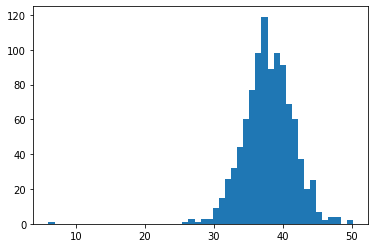

[6,
 44.430327457392536,
 38.69386343424733,
 36.80216595270037,
 35.45029040719861,
 34.1681098782169,
 35.679446941659656,
 39.8249196959258,
 32.352613739792126,
 40.5654408722107,
 39.70867191919057,
 42.383036911862796,
 34.43747205213744,
 37.065918532357976,
 32.99075629169633,
 37.82155100094156,
 38.85103963371598,
 34.79831716917093,
 31.432769784384746,
 36.39124871721473,
 40.63326994081529,
 35.372901401365965,
 40.14182393744356,
 38.076902211405056,
 39.19068607812673,
 30.96882988388613,
 44.751585775743955,
 43.08114696230532,
 35.47795135628724,
 46.34024102826383,
 40.02540397276338,
 38.837055092991285,
 39.36475010244691,
 37.684733974668944,
 37.153324591128786,
 38.134430315031196,
 34.70164129735894,
 37.33355934699855,
 34.49391122604414,
 34.392634891270426,
 38.94181146239529,
 39.89524181546775,
 43.24657589352961,
 44.48869529306489,
 38.399883787612204,
 38.4533239874009,
 32.88767751119615,
 44.33618956656019,
 44.23194462818462,
 37.61061646339964,
 35.5

In [551]:
plt.hist(trace["proposal_b0"],bins=50)
plt.show()
pprint.pprint(trace["proposal_b0"])
print(min(trace["proposal_b0"]), max(trace["proposal_b0"]))

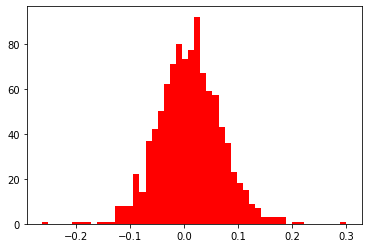

[0.3,
 -0.2632785585322466,
 -0.0019305760206026895,
 0.07157161184767097,
 0.051984146346228985,
 0.08781422118144108,
 -0.02002926427124738,
 0.10436550828539781,
 -0.005230891204562757,
 0.01567450501823751,
 -0.08094527934055569,
 -0.0960881734663096,
 0.0338068203589084,
 0.12445400037414471,
 0.0824497329081414,
 0.13456431596775606,
 0.01734696826909168,
 0.1675893129486295,
 -0.0089611971514943,
 -0.009988330928160347,
 0.004684685028086617,
 -0.10101620041866041,
 0.056702121304581174,
 -0.022967935036393286,
 -0.029245281144567828,
 0.14926862373220895,
 -0.008467158798835318,
 0.03805512560451843,
 0.0007687619333640941,
 -0.08496522141526695,
 0.11260210469036806,
 -0.01816901716066177,
 0.031072480705287994,
 0.07162823273247036,
 -0.03722563803646779,
 0.08100490126735241,
 -0.021912487717870115,
 0.07490438454272542,
 0.017688168470772245,
 0.04721799033974797,
 0.013524075426959744,
 -0.016079332118667404,
 -0.04996332002310967,
 0.0539789807159191,
 -0.0003494409367892

In [552]:
plt.hist(trace["proposal_b1"], color="r", bins=50)
plt.show()
pprint.pprint(trace["proposal_b1"])
print(min(trace["proposal_b1"]), max(trace["proposal_b1"]))

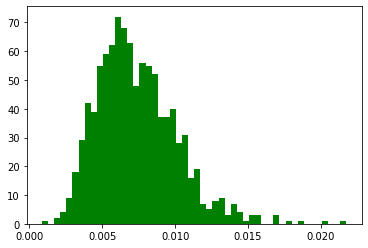

[None,
 0.0008738065726840181,
 0.006479852957202449,
 0.011005995470648887,
 0.005016822397480968,
 0.00427186877560231,
 0.0077779887047868795,
 0.006345969880566314,
 0.007506899478792315,
 0.005902925949096329,
 0.005186179814978896,
 0.004288151454726723,
 0.003955836022938648,
 0.006157362027296097,
 0.010347240535068873,
 0.006611557959332928,
 0.009277184815851899,
 0.007541373645536203,
 0.006913437331606863,
 0.00959782861341268,
 0.004036538679992587,
 0.008421774116273803,
 0.005127706744043794,
 0.008294524101025292,
 0.009846748848859367,
 0.006708981471845215,
 0.006122150505755821,
 0.005044545313697216,
 0.0038984662818355043,
 0.0039008924169377217,
 0.005705656961518899,
 0.008458569000487502,
 0.006843230491248497,
 0.008819202952097338,
 0.012912711589740526,
 0.007213219542247021,
 0.010001963576195464,
 0.007948230691870756,
 0.017586885245641226,
 0.007625550667164056,
 0.008739107081474818,
 0.010495763575708352,
 0.0069594364115096894,
 0.005638767957806764,
 

In [553]:
plt.hist(trace["proposal_tau"][1:], color="g", bins=50)
plt.show()
pprint.pprint(trace["proposal_tau"])
print(min(trace["proposal_tau"][1:]), max(trace["proposal_tau"][1:]))

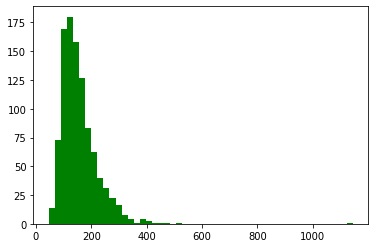

In [554]:
plt.hist([1/x for x in trace["proposal_tau"][1:]], color="g", bins=50)
plt.show()

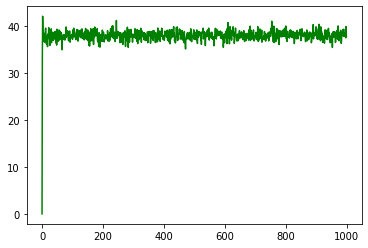

[0,
 33.35485402356185,
 42.01528512844451,
 38.11520443344057,
 36.9866090414477,
 37.27140548520899,
 36.76061177428308,
 38.36946381339773,
 36.51142593675687,
 38.144716691002486,
 37.8255921808728,
 39.26247227848916,
 39.484114393221134,
 37.56156257025225,
 36.219187516661904,
 36.83544486377201,
 36.064952001863915,
 37.815699267991064,
 35.56120177138245,
 38.217205560246946,
 38.19607442358462,
 38.00897519703121,
 39.573126275285425,
 37.22887905841538,
 38.4278350844304,
 38.50974569300183,
 35.83128578621781,
 38.18587580925113,
 37.474422405786896,
 38.03280343838656,
 39.33784809201693,
 36.391619512264434,
 38.3445134132801,
 37.614812100386615,
 37.01579906208667,
 38.632013077160565,
 36.86968484990462,
 38.40580735212918,
 36.97175267013334,
 37.810954435581564,
 37.3725536596243,
 37.88241016972806,
 38.31382128062363,
 38.81289498308455,
 37.274264153316096,
 38.086842413389924,
 36.3190820001543,
 37.40646031901112,
 35.886917966398954,
 39.26651646877463,
 37.217

In [555]:
plt.plot(trace["mu0"], color="g")
plt.show()
pprint.pprint(trace["mu0"])

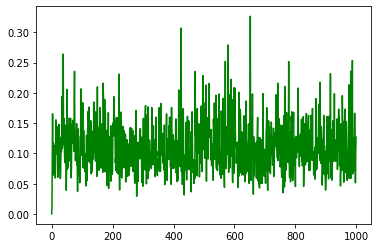

[0.0001,
 0.013207098590260272,
 0.09729779435803673,
 0.16518993205973329,
 0.07535233596221452,
 0.06417803163403464,
 0.1167698305718032,
 0.09528954820849471,
 0.11270349218188473,
 0.08864388923644494,
 0.07789269722468344,
 0.06442227182090085,
 0.05943754034407973,
 0.09246043040944146,
 0.15530860802603308,
 0.09927336938999393,
 0.13925777223777847,
 0.11322060468304306,
 0.10380155997410295,
 0.14406742920119017,
 0.0606480801998888,
 0.12642661174410702,
 0.07701560116065691,
 0.12451786151537937,
 0.1478012327328905,
 0.10073472207767822,
 0.09193225758633732,
 0.07576817970545824,
 0.05857699422753257,
 0.05861338625406583,
 0.0856848544227835,
 0.12697853500731252,
 0.10274845736872747,
 0.13238804428146006,
 0.19379067384610787,
 0.10829829313370531,
 0.15012945364293195,
 0.11932346037806134,
 0.2639032786846184,
 0.11448326000746084,
 0.13118660622212225,
 0.15753645363562527,
 0.10449154617264535,
 0.08468151936710146,
 0.14693885546096272,
 0.13743632281827045,
 0.13

In [556]:
plt.plot(trace["tau0"], color="g")
plt.show()
pprint.pprint(trace["tau0"])

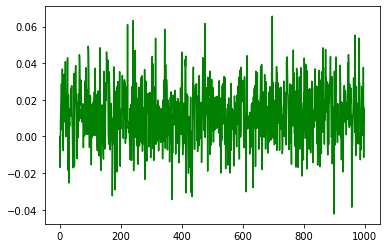

[0,
 -0.016923096122541854,
 0.008572258666733942,
 0.01697980259485754,
 0.022988132348826493,
 0.028686708264201995,
 0.021969662334165935,
 0.0035453434577591585,
 0.03675558358365914,
 0.000254139248341385,
 0.004061999799675616,
 -0.007824061683189103,
 0.02748954258484944,
 0.01580756688381568,
 0.033919397660390684,
 0.012449201708516012,
 0.00787369871688429,
 0.02588579345552917,
 0.04084377694271922,
 0.0188061005962565,
 -4.732317058903756e-05,
 0.023332087064649093,
 0.0021368804425082495,
 0.01131430846472887,
 0.006364159363741189,
 0.04290573109331105,
 -0.018350943205841082,
 -0.010926772343960556,
 0.02286519226306637,
 -0.02541162627018796,
 0.002654302412003957,
 0.007935852054453206,
 0.0055905411408389335,
 0.013057278175691958,
 0.015419098223916955,
 0.011058627670269935,
 0.02631546558007398,
 0.014618053590311257,
 0.027238712479194994,
 0.027688825409545502,
 0.007470268355163418,
 0.0032328011993826462,
 -0.01166201300687279,
 -0.017182540962331922,
 0.009878

In [557]:
plt.plot(trace["mu1"], color="g")
plt.show()
pprint.pprint(trace["mu1"])

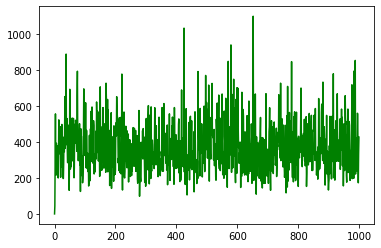

[0.0001,
 44.23655774212842,
 328.0426559583739,
 557.1786207015999,
 253.976733872474,
 216.26345676486693,
 393.76077817983577,
 321.26482520366966,
 380.03688611386093,
 298.83572617300166,
 262.5504531333066,
 217.08776739554034,
 200.26429866126907,
 311.7165526318649,
 523.8291520878616,
 334.71022169122944,
 469.65758130250236,
 381.7821408052703,
 349.99286491259744,
 485.8901735540169,
 204.3498706746247,
 426.35241463636123,
 259.590253917217,
 419.91038261440536,
 498.49176047350545,
 339.642287012164,
 309.9339693538884,
 255.38020650592156,
 197.3599555179224,
 197.48277860747217,
 288.84898367689425,
 428.21515564967973,
 346.43864361945515,
 446.47224944992774,
 653.7061242306141,
 365.1693393262554,
 506.34950604489535,
 402.379278775957,
 890.336165560587,
 386.0436025251803,
 442.41739599966263,
 531.3481310202353,
 352.321568332678,
 285.4627278639674,
 495.5812371807492,
 463.51018951166276,
 440.5862523785649,
 403.31462486108353,
 131.49784836032134,
 297.56978622

In [558]:
plt.plot(trace["tau1"], color="g")
plt.show()
pprint.pprint(trace["tau1"])